<a href="https://colab.research.google.com/github/priyansh4320/TEXT-DRIVEN-VISUAL-TRANSLATION-SKETCH-TO-PHOTO-GUIDED-SYNTHESIS/blob/main/college_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.6 MB/s eta 0:00:00


# TEXT-DRIVEN VISUAL TRANSLATION: SKETCH-TO-PHOTO GUIDED SYNTHESIS


In [ ]:
#!pip install gradioa
!pip install --upgrade -q gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.4 MB/s eta 

In [ ]:
!pip install -q accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
#controlnet
# !pip install opencv-python transformers accelerate
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
import numpy as np
import torch

import cv2
from PIL import Image


ModuleNotFoundError: No module named 'diffusers'

In [ ]:

import PIL

In [ ]:
# prompt: load a pil image

# Load the image as a PIL image
image = PIL.Image.open('/content/ip1.png')


In [ ]:


image = load_image(
    "/content/ip1.png"
)
#image.save("1.png")

In [ ]:
#input image of dimension 512 x 512 , format .png
image

In [ ]:


# load control net and stable diffusion v1-5
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16,
     safety_checker = None,
    requires_safety_checker = False
)

In [ ]:
# speed up diffusion process with faster scheduler and memory optimization

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()



In [ ]:
def get_control_image(image):
  np_image = np.array(image)
  # get canny image
  np_image = cv2.Canny(np_image, 100, 200)
  np_image = np_image[:, :, None]
  np_image = np.concatenate([np_image, np_image, np_image], axis=2)
  canny_image = PIL.Image.fromarray(np_image)
  return canny_image
#canny_image = get_control_image(image)

In [ ]:
#pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
#pipe.enable_model_cpu_offload()
def generate(ip_image,control_image,prompt):
  generator = torch.manual_seed(0)
  image = pipe(
      prompt=prompt,
      num_inference_steps=30,
      generator=generator,
      image=ip_image,
      control_image=control_image,
  ).images[0]
  return image
#generate(image,canny_image,"an abstract art of japanese women")

In [ ]:
# prompt: save the generated image
image.save("gen_girl.jpg")


In [ ]:
# image generation function
def image_to_image(input_png_image, prompt):
  image = PIL.Image.fromarray(input_png_image)
  image = load_image(image)
  control_image = get_control_image(image)
  generated_image = generate(image,control_image,prompt)
  return generated_image

In [ ]:
img  =  image_to_image("/content/ip1.png",'a hyper realistic indian women')

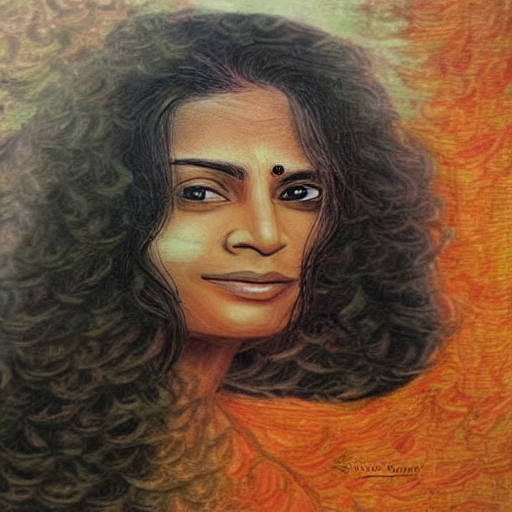

In [ ]:
img

In [ ]:
import gradio as gr

from gradio import Image, Textbox
from gradio import Image


interface = gr.Interface(
    fn = image_to_image,
    inputs=[Image(label="Input Image"), Textbox(label="Text Prompt")],
    outputs=Image(label="Generated Image"),
    title="Text-Driven Visual Translation: Sketch-to-Photo Guided Synthesis",
    description="Use pretrained Stable Diffusion model so as to perform Text-Driven Image Synthesis.",
   elem_id="my-image-to-image-app",
)

# Launch the Gradio interface in the notebook
interface.launch(share=True,debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://a4c67dc29f4e399a1a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
!gradio app.py


Watching: '/content' '/content'

2024-04-17 19:29:22.566345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 19:29:22.566462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 19:29:22.585516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 19:29:27.483249: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading pipeline components...: 100% 6/6 [00:40<00:00,  6.75s/it]
Traceback (most recent call last):
  File "/content/app.py", line 60, in <module>
    inputs=[Image(label="Input Image"), Textbox(label="Text

In [ ]:
!pip install PIL

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [ ]:
!gradio deploy

Space available at https://huggingface.co/spaces/Priyansh4320/img-to-img_generation
